In [1]:
import joblib
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

#### 1. Carregar dados tratados

In [2]:
# read pickle file
df_enem = pd.read_pickle('Bases\MICRODADOS_ENEM_2023_tratados.pkl')

In [3]:
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']

df_enem_X = df_enem.drop(columns=variaveis_alvo)
df_enem_y = df_enem[variaveis_alvo]

#### 2. Funções padrão reutilizadas ao lonfo do código

In [4]:
# Função para exibir DataFrame de importâncias
def mostrar_importancias_df(series, tecnica='Importância das Variáveis'):
    nome_feature = 'Feature' if tecnica == 'Informação Mútua' else 'Variável'
    nome_importancia = 'MI' if tecnica == 'Informação Mútua' else 'Importância'
    df = pd.DataFrame({
        nome_feature: series.index,
        nome_importancia: series.values.round(4)
    })
    print(f"Técnica: {tecnica}")
    display(df)

# Função para plotar gráfico de barras das importâncias
def plotar_importancias(series, tecnica='Importância das Variáveis', alvo=None):
    if tecnica == 'Informação Mútua':
        titulo = f'Informação Mútua entre Features e {alvo}' if alvo else 'Informação Mútua'
        xlabel = 'Informação Mútua (MI)'
        ylabel = 'Features'
    else:
        titulo = 'Importâncias das Variáveis - Random Forest'
        xlabel = 'Importância'
        ylabel = 'Variáveis'
    plt.figure(figsize=(10, 8))
    sns.barplot(x=series.values, y=series.index, palette='viridis', hue=series.index)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

#### 3. Aplicar Método da Informação Mútua

In [7]:
df_enem_mi = df_enem_X.copy()

In [8]:
# Aplicar o LabelEncoder para converter as colunas categóricas em numéricas
# Salvar os encoders para possível uso posterior
label_encoders = {}
categorical_columns = df_enem.select_dtypes(include=['category']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df_enem[col] = le.fit_transform(df_enem[col])
    label_encoders[col] = le  # Salvar o encoder para a coluna

In [9]:
df_enem_mi

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,CAT_COR_RACA,CAT_CO_MUNICIPIO_ESC,CAT_CO_UF_ESC,...,NUM_Q011,NUM_Q012,NUM_Q013,NUM_Q014,NUM_Q015,NUM_Q016,NUM_Q017,NUM_Q019,NUM_Q022,NUM_Q024
0,False,False,False,False,False,False,True,3,2304400,23,...,0,1,0,0,0,0,0,1,3,0
1,False,False,False,False,False,False,False,3,2311306,23,...,0,1,0,0,0,0,0,1,1,0
2,False,False,False,False,False,False,True,3,4128005,41,...,0,1,0,1,0,0,0,1,1,1
3,False,False,False,False,False,True,True,1,1501402,15,...,0,1,0,0,0,0,0,1,3,0
4,False,False,False,False,False,False,True,1,3550308,35,...,0,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716565,False,True,True,True,True,True,True,1,4307708,43,...,0,1,2,1,0,1,0,5,5,1
716566,False,False,True,False,True,False,True,1,4304713,43,...,0,1,1,1,0,1,0,1,2,1
716567,False,False,True,False,False,False,True,1,4318705,43,...,0,1,1,1,1,1,0,5,5,3
716568,False,False,True,False,True,False,True,1,4304630,43,...,0,1,1,1,1,1,0,3,5,1


    discrete_features: 
        - 'True' para variáveis categóricas nominais ou ordinais, variáveis binárias ou numéricas contáveis;
        - 'False' apenas se for variável numérica contínua

In [10]:
# Função para calcular MI de uma única feature
def compute_mi(feature: str, alvo: str):
    return mutual_info_regression(df_enem_mi[[feature]], df_enem_y[alvo], discrete_features=True)[0]

In [11]:
# Lista de features
features = df_enem_mi.columns
alvo = 'NUM_NOTA_CH'

# Paralelizar o cálculo
mi_scores = Parallel(n_jobs=-1)(delayed(compute_mi)(f, alvo) for f in features)

# Organizar em DataFrame
mi_series = pd.Series(mi_scores, index=features).sort_values(ascending=False)

In [12]:
mostrar_importancias_df(mi_series, tecnica='Informação Mútua')

Técnica: Informação Mútua


,Feature,MI
0,NUM_Q006,0.1107
1,CAT_DEPENDENCIA_ADM_ESC,0.0983
2,NUM_Q024,0.0877
3,CAT_CO_MUNICIPIO_ESC,0.0788
4,CAT_ESCOLA,0.0774
5,CAT_Q003,0.0759
6,CAT_Q004,0.0670
7,NUM_Q002,0.0636
8,NUM_Q001,0.0626
9,NUM_Q008,0.0558


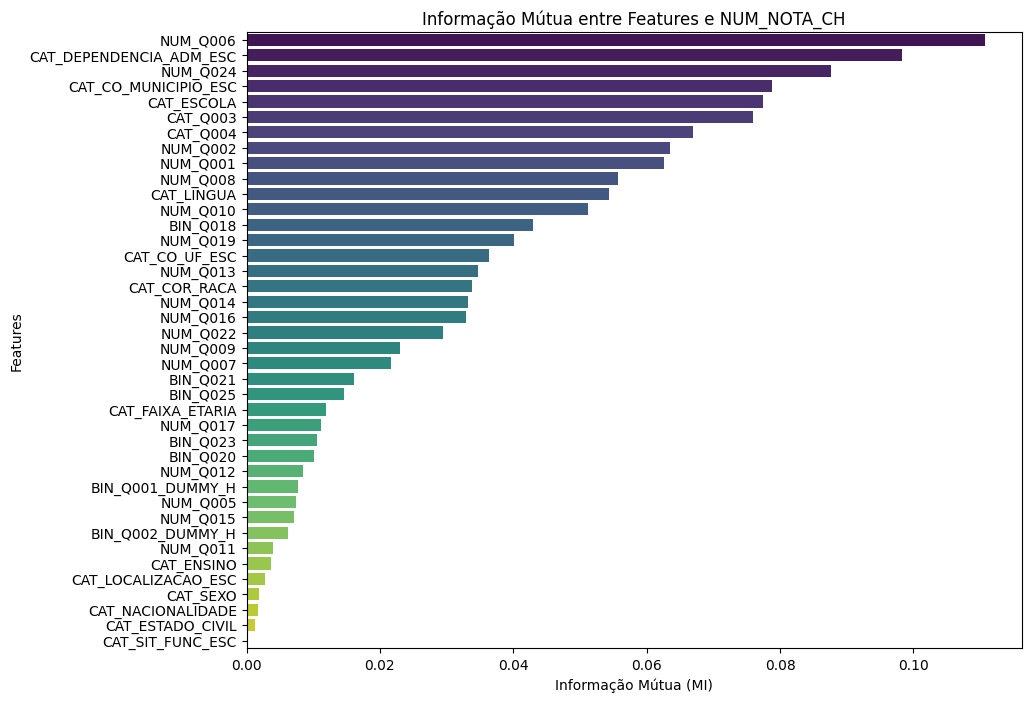

In [13]:
plotar_importancias(mi_series, tecnica='Informação Mútua', alvo=alvo)

#### 4. Aplicar Método da Importancia das Variáveis com modelo Random Forest

    Executar apenas após ter gerado o modelo de Random Forest

In [14]:
# Carregar modelo random forest já treinado de arquivo
modelo = joblib.load('Modelos/modelo_random_forest_base.pkl')

In [15]:
importances_series = pd.Series(modelo.feature_importances_, index=df_enem_X.columns).sort_values(ascending=False)

In [16]:
mostrar_importancias_df(importances_series, tecnica='Importância das Variáveis')

Técnica: Importância das Variáveis


,Variável,Importância
0,CAT_CO_MUNICIPIO_ESC,0.0953
1,NUM_Q006,0.0809
2,CAT_DEPENDENCIA_ADM_ESC,0.0582
3,CAT_CO_UF_ESC,0.0540
4,NUM_Q001,0.0488
5,NUM_Q002,0.0450
6,NUM_Q024,0.0438
7,CAT_LINGUA,0.0413
8,NUM_Q005,0.0399
9,CAT_Q003,0.0393


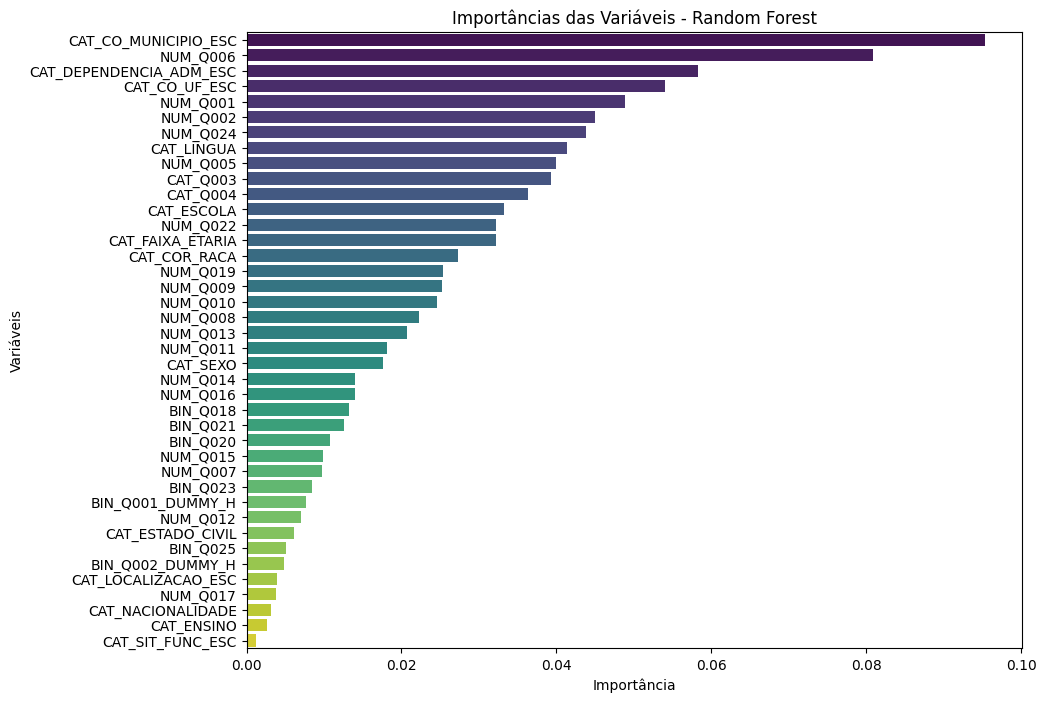

In [17]:
plotar_importancias(importances_series, tecnica='Importância das Variáveis')

#### 5. Comparativo Informação Mútua e Importância Random Forest 

,Informação Mútua,Importância das Variáveis (Random Forest)
CAT_SIT_FUNC_ESC,0.000267,0.001209
CAT_NACIONALIDADE,0.001791,0.003207
CAT_ENSINO,0.003702,0.002641
CAT_LOCALIZACAO_ESC,0.002800,0.003943
CAT_ESTADO_CIVIL,0.001263,0.006093
BIN_Q002_DUMMY_H,0.006150,0.004815
NUM_Q017,0.011188,0.003836
BIN_Q001_DUMMY_H,0.007685,0.007673
NUM_Q012,0.008455,0.007031
NUM_Q015,0.007149,0.009926


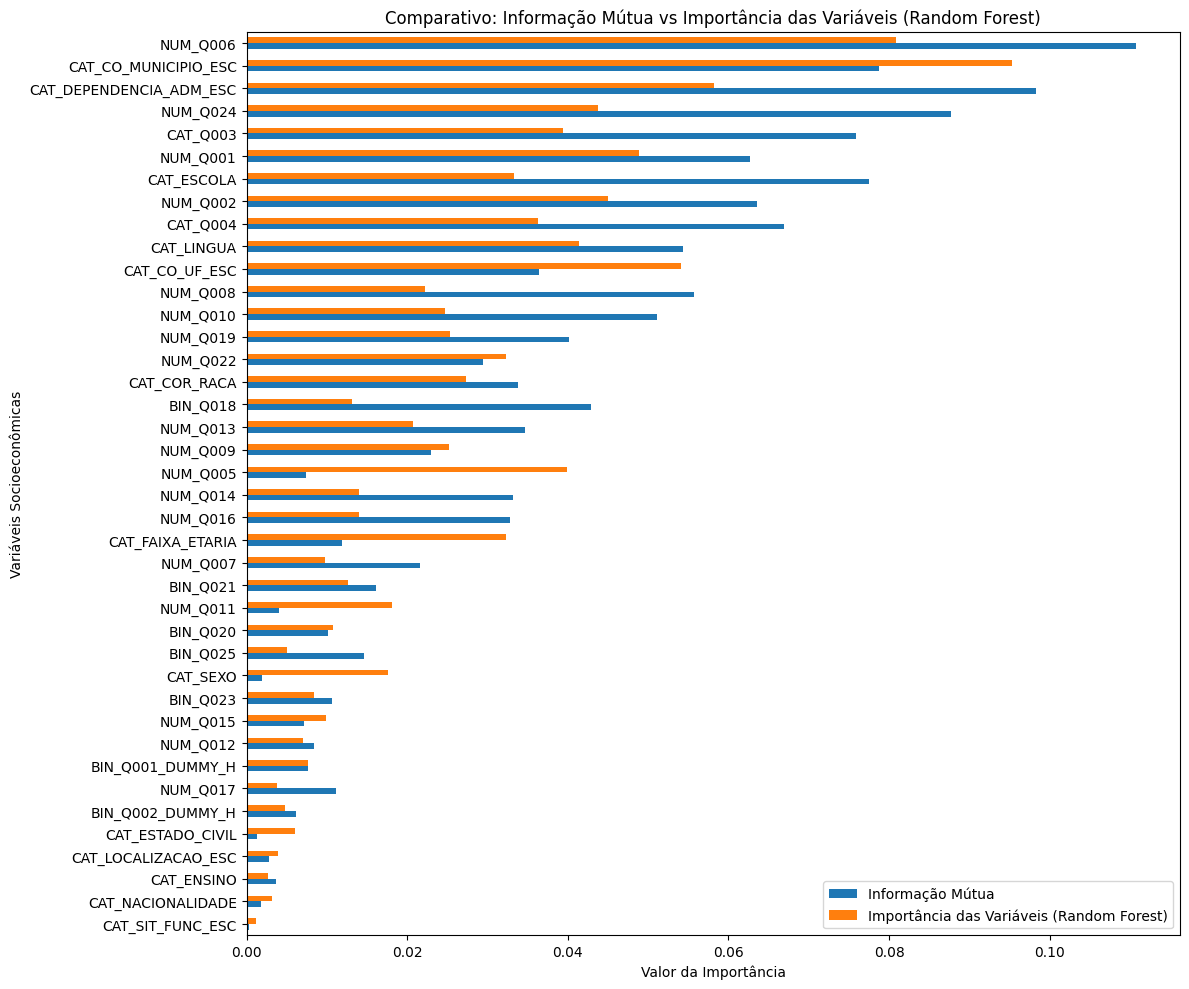

In [18]:
# Unir os dois resultados em um DataFrame para comparação
comparativo_df = pd.DataFrame({
    'Informação Mútua': mi_series,
    'Importância das Variáveis (Random Forest)': importances_series
})

# Exibir o DataFrame ordenado pela soma das importâncias (opcional)
comparativo_df['Soma'] = comparativo_df.sum(axis=1)
comparativo_df = comparativo_df.sort_values('Soma', ascending=True)
display(comparativo_df.drop(columns='Soma'))

# Plotar gráfico comparativo
comparativo_df.drop(columns='Soma').plot(kind='barh', figsize=(12, 10))
plt.title('Comparativo: Informação Mútua vs Importância das Variáveis (Random Forest)')
plt.xlabel('Valor da Importância')
plt.ylabel('Variáveis Socioeconômicas')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

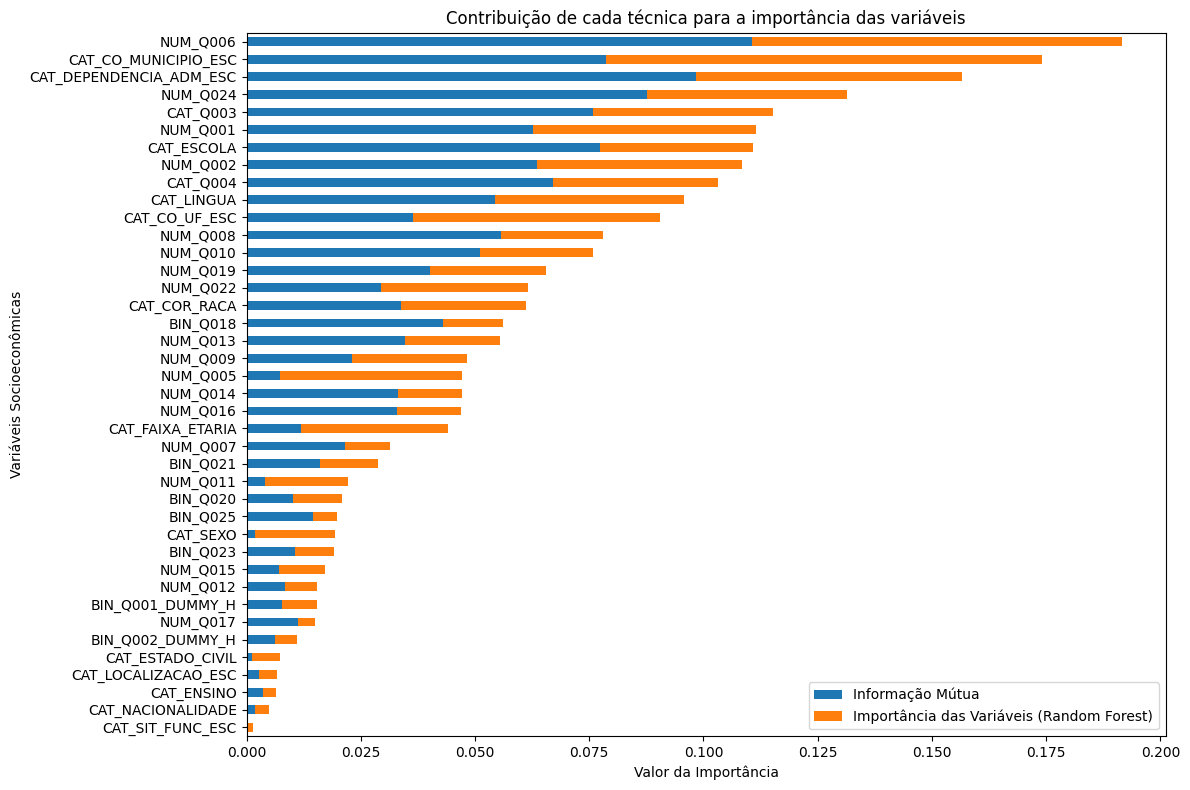

In [19]:
# Gráfico de barras empilhadas mostrando a contribuição de cada técnica
ax = comparativo_df[['Informação Mútua', 'Importância das Variáveis (Random Forest)']].plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    color=['#1f77b4', '#ff7f0e']  # azul e laranja
)
plt.title('Contribuição de cada técnica para a importância das variáveis')
plt.xlabel('Valor da Importância')
plt.ylabel('Variáveis Socioeconômicas')
plt.legend(['Informação Mútua', 'Importância das Variáveis (Random Forest)'], loc='lower right')
plt.tight_layout()
plt.show()

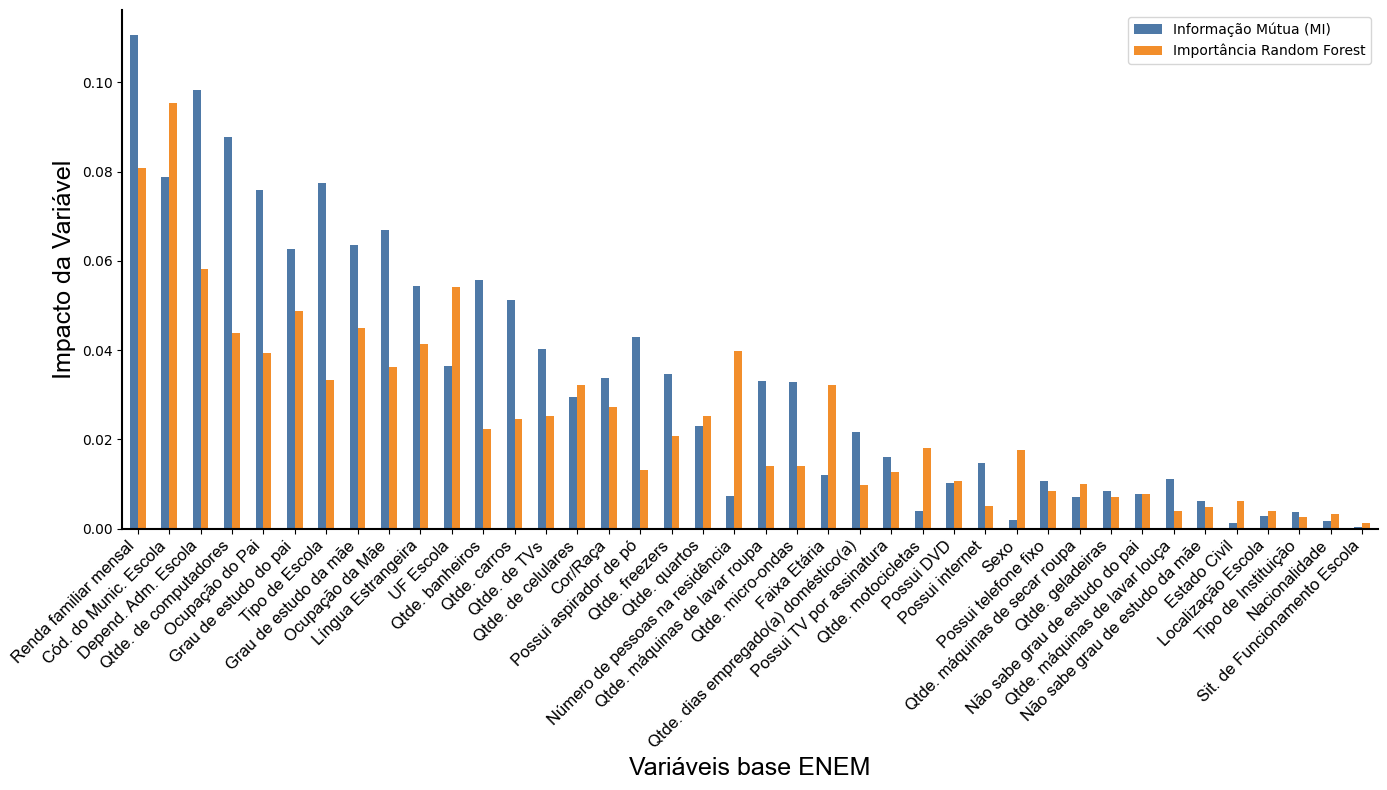

In [20]:
# Ordenar do maior para o menor pela soma das importâncias
df_plot = comparativo_df.drop(columns='Soma')
df_plot = df_plot.loc[comparativo_df['Soma'].sort_values(ascending=False).index]

# Dicionário de-para para nomes mais claros
nomes_claros = {
    'CAT_CO_MUNICIPIO_ESC': 'Cód. do Munic. Escola',
    'CAT_COR_RACA': 'Cor/Raça',
    'CAT_SEXO': 'Sexo',
    'CAT_DEPENDENCIA_ADM_ESC': 'Depend. Adm. Escola',
    'CAT_ESCOLA': 'Tipo de Escola',
    'CAT_Q003': 'Ocupação do Pai',
    'CAT_Q004': 'Ocupação da Mãe',
    'CAT_LINGUA': 'Língua Estrangeira',
    'CAT_CO_UF_ESC': 'UF Escola',
    'CAT_NACIONALIDADE': 'Nacionalidade',
    'CAT_ENSINO': 'Tipo de Instituição',
    'CAT_LOCALIZACAO_ESC': 'Localização Escola',
    'CAT_ESTADO_CIVIL': 'Estado Civil',
    'CAT_SIT_FUNC_ESC': 'Sit. de Funcionamento Escola',
    'CAT_FAIXA_ETARIA': 'Faixa Etária',
    'BIN_Q001_DUMMY_H': 'Não sabe grau de estudo do pai',
    'BIN_Q002_DUMMY_H': 'Não sabe grau de estudo da mãe',
    'BIN_Q018': 'Possui aspirador de pó',
    'BIN_Q020': 'Possui DVD',
    'BIN_Q021': 'Possui TV por assinatura',
    'BIN_Q023': 'Possui telefone fixo',
    'BIN_Q025': 'Possui internet',
    'NUM_Q001': 'Grau de estudo do pai',
    'NUM_Q002': 'Grau de estudo da mãe',
    'NUM_Q005': 'Número de pessoas na residência',
    'NUM_Q006': 'Renda familiar mensal',
    'NUM_Q007': 'Qtde. dias empregado(a) doméstico(a)',
    'NUM_Q008': 'Qtde. banheiros',
    'NUM_Q009': 'Qtde. quartos',
    'NUM_Q010': 'Qtde. carros',
    'NUM_Q011': 'Qtde. motocicletas',
    'NUM_Q012': 'Qtde. geladeiras',
    'NUM_Q013': 'Qtde. freezers',
    'NUM_Q014': 'Qtde. máquinas de lavar roupa',
    'NUM_Q015': 'Qtde. máquinas de secar roupa',
    'NUM_Q016': 'Qtde. micro-ondas',
    'NUM_Q017': 'Qtde. máquinas de lavar louça',
    'NUM_Q019': 'Qtde. de TVs',
    'NUM_Q022': 'Qtde. de celulares',
    'NUM_Q024': 'Qtde. de computadores',
}

# Renomear índices do DataFrame para plot
df_plot_renomeado = df_plot.rename(index=nomes_claros)

# Gráfico de barras verticais lado a lado para todas as variáveis
ax = df_plot_renomeado.plot(
    kind='bar',
    figsize=(max(14, len(df_plot_renomeado) * 0.25), 8),
    color=['#4e79a7', '#f28e2b']
)
# Remover título
# plt.title('Importância das Variáveis: Informação Mútua vs Random Forest')  # Removido

plt.ylabel('Impacto da Variável', fontsize=18, fontname='Arial', color='black')
plt.xlabel('Variáveis base ENEM', fontsize=18, fontname='Arial', color='black')
plt.xticks(rotation=45, ha='right', fontsize=12, fontname='Arial', color='black')
plt.legend(['Informação Mútua (MI)', 'Importância Random Forest'])

# Remover grades
ax.grid(False)

# Remover todas as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Destacar apenas os eixos principal inferior (bottom) e esquerdo (left)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)

plt.tight_layout()
plt.show()